Если делать локально, то не нужно выполнять слудеющую ячейку.

Также убрать из всех путей "/midIR"

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов
from numpy.fft import fft, rfft, irfft
import matplotlib as mpl
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Image,display

from reparse import reparse
import fourier
import data_from_input
import scipy
from source import source
from matplotlib.colors import LogNorm

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [3]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508
RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10
ElectronsPerCell = 2.35165e+16/18

rep = reparse()

# Theory


In [4]:
n_0, t_long, x_long, dxdt_long, az_i_long, az_r_long = rep.analytical_linear("./data/theory/linear/long1")

['./2.00/linear_long_n0_2.00.bin', './3.00/linear_long_n0_3.00.bin', './4.00/linear_long_n0_4.00.bin', './5.00/linear_long_n0_5.00.bin', './6.00/linear_long_n0_6.00.bin', './7.00/linear_long_n0_7.00.bin', './8.00/linear_long_n0_8.00.bin', './9.00/linear_long_n0_9.00.bin']


In [5]:
n_0

['2.00', '3.00', '4.00', '5.00', '6.00', '7.00', '8.00', '9.00']

(0.0, 150.0, -40.0, 40.0)

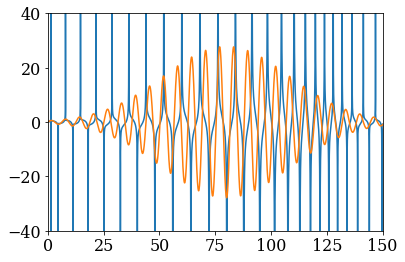

In [6]:
plt.plot(t_long[3], az_r_long[3])
plt.plot(t_long[3], az_i_long[3])
plt.axis([0,150, -40, 40])

In [7]:
fourier_i_ad, fourier_r_ad, base_ad, omega_ad, flambda_ad, fourierl_i_ad, fourierl_r_ad = fourier.fourier_of_field(az_i_long[3][1::100], az_r_long[3][1::100], 0.8, True)

# Compare

Ниже на картинках:

нижние индексы i,r различают падающие/отраженные поля;

верхние индесы t,s показывают способ получения результата (теория, моделирование);

ключевые слова steep, long различают форму падающего импульса (с резким и плавным передними фронтами соответственно), где не указано, подразумеваются импульсы с резким передним фронтом.

## Code

### Выберите параметры с помощью выпадающего списка ниже (осторожно с колёсиком)

In [8]:
def f(x):
    return x 
w = interactive(f, x=[('steep 8.70', r'./data/source/steep/energy1_n_8.70_ll_2022-02-26_11-22-52'),
                      ('steep 41.64', r'./data/source/steep/energy4_n_41.64_ll_2022-02-26_10-37-29'),
                      ('long 11.94', r'./data/source/long/energy11_n_11.94_ll_2022-02-25_14-30-02'),
                      ('long 30.30', r'./data/source/long/energy9_n_30.30_ll_2022-02-25_17-22-19')])
w

interactive(children=(Dropdown(description='x', options=(('steep 8.70', './data/source/steep/energy1_n_8.70_ll…

In [9]:
name =  w.result

idx = name.find("_", name.find("_") + 1)

n_0 = name[idx+1:-23]
print(n_0)

def reparce(files, name, field):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/RelativisticField)
    return bz

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

bz_i = np.array(reparce(files[100:101], name, "bz2dxy")).T[:,0]
bz_r = np.array(reparce(files[550:551], name, "bz2dxy")).T[:,0]
by_i = np.array(reparce(files[100:101], name, "by2dxy")).T[:,0]
by_r = np.array(reparce(files[550:551], name, "by2dxy")).T[:,0]

fourier_w_base_z, fourier_w_addon_z, fmax_z, omega_z, flambda_z, fourier_l_base_z, fourier_l_addon_z = fourier.fourier_of_field(bz_i, bz_r, 0.8, True)
fourier_w_base_y, fourier_w_addon_y, fmax_y, omega_y, flambda_y, fourier_l_base_y, fourier_l_addon_y = fourier.fourier_of_field(by_i, by_r, 0.8, True)

11.94


In [10]:
range1 = (3,20)
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)
# привязка пространственных частот через известное падающее поле
rfft_i = abs(np.fft.rfft(bz_i))
argmax = np.unravel_index(np.argmax(rfft_i, axis = None), rfft_i.shape)[0]


k_x = np.arange(1,np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x
filter_range = np.where((lambda_i<range1[1]) & (lambda_i>range1[0]),1,0)
#print(lambda_i[argmax])

#filter_shape = filter_gauss(np.arange(len(rfft_i)), sum(filter_range)/2, (filter_range[1] - filter_range[0])/2)

filtered_fft_r = (np.fft.rfft(bz_r))[1:]*filter_range[:]

filtered_r = np.fft.irfft(filtered_fft_r)

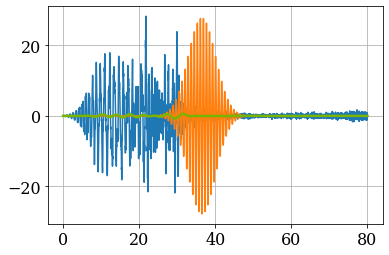

In [11]:
plt.plot(np.linspace(0,80,len(bz_r)),bz_r)
plt.plot(np.linspace(0,80,len(bz_r)),bz_i)
plt.plot(np.linspace(0,80,len(filtered_r)),filtered_r, linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
plt.grid()
#plt.axis([5, 40,-1.0,1.0])

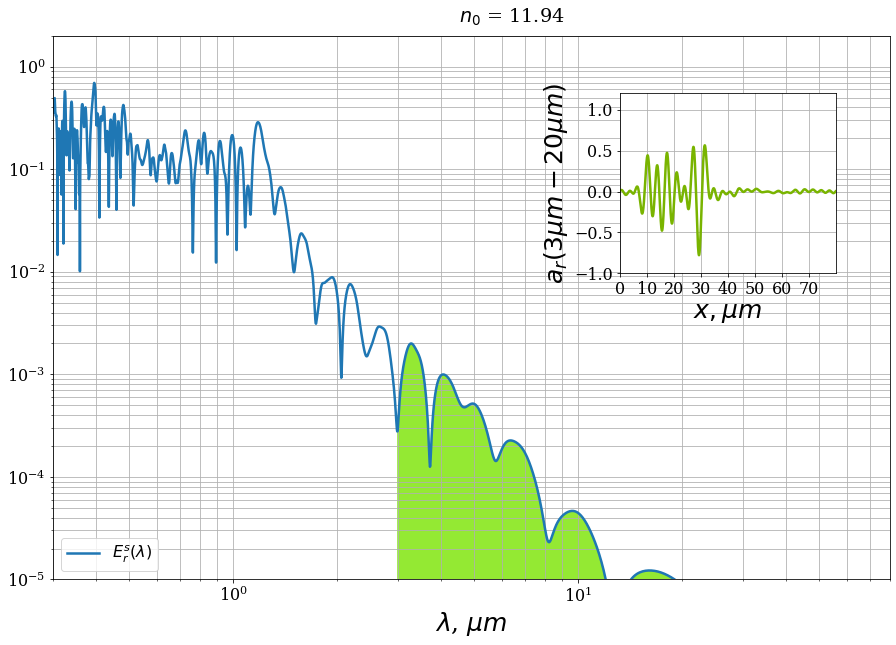

In [12]:
fig = plt.figure(figsize = (15,10))

filter_range_ii = np.where((flambda_z<range1[1]) & (flambda_z>range1[0]),1,0)

ax1 = plt.axes()  # standard axes
plt.xlabel(r"$\lambda$, $\mu m$", fontsize=25)
plt.fill_between(flambda_z ,abs(fourier_l_addon_z)*filter_range_ii, 1e-8, color=(121/255, 228/255, 0, 0.8))
ax2 = plt.axes([0.65, 0.55, 0.20, 0.25])

plt.suptitle(r"$n_0$ = {}".format(n_0), y = 0.92, x = 0.55)

#ax1.loglog(flambda_ad[:] , abs(fourierl_i_ad[:]), linewidth = 2.5, label = r'$E^t_{i}(\lambda)$', linestyle = (0,(1,1)))
#ax1.loglog(flambda_ad[:] , abs(fourierl_r_ad[:]), linewidth = 2.5, label = r'$E^t_{r}(\lambda)$', linestyle = (0,(5,2)))
#ax1.loglog(flambda_sim[:] , abs(fourierl_i_sim[:]), linewidth = 2.5, label = r'$E^s_{i}(\lambda)$')
ax1.loglog(flambda_z, abs(fourier_l_addon_z), linewidth = 2.5, label = r'$E^s_{r}(\lambda)$')
ax1.legend(loc = "lower left")
ax1.axis((3e-1,8e+1,1e-5,2))
ax2.plot(np.linspace(0,80,len(filtered_r)),filtered_r, linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
ax2.set_xticks(np.arange(0,80,10))
ax2.set_yticks(np.arange(-4,5,0.5))
ax2.axis([-0, 80,-1.0,1.2])
plt.xlabel(r"$x, \mu m$", fontsize=25)
plt.ylabel(r"$a_r({}\mu m-{}\mu m)$".format(range1[0], range1[1]), fontsize=25)
ax1.grid(True, which="both")
ax2.grid(True, which="both")
plt.show()

### Проверьте параметры, если подходят для статьи, то посчитаю теорию и получится что-то типа следующей картиночки(не исполнять ячейку)

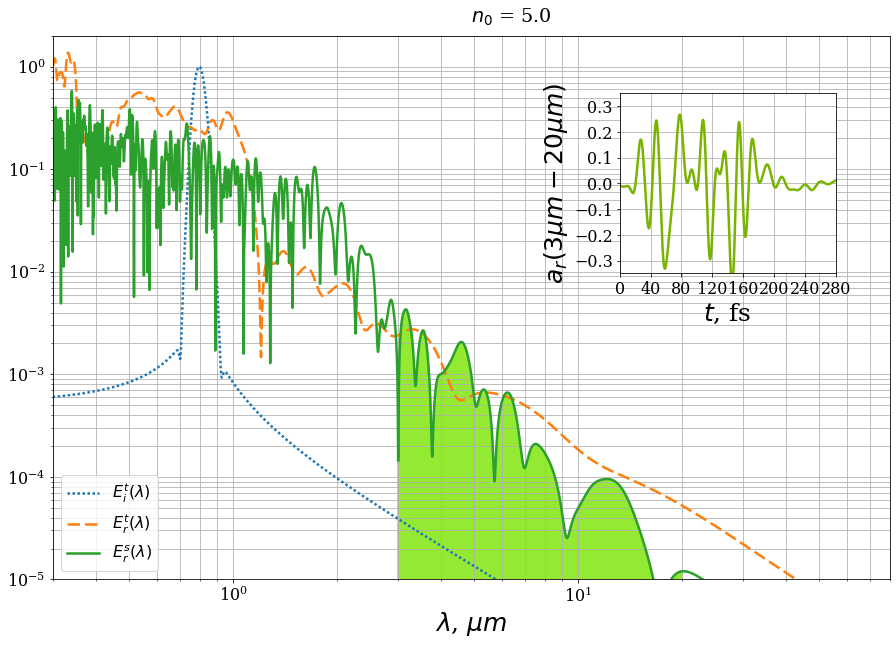

In [13]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.axes()  # standard axes
plt.xlabel(r"$\lambda$, $\mu m$", fontsize=25)
plt.fill_between(flambda_sim[:] ,abs(spec_filtered_linear), 1e-8, color=(121/255, 228/255, 0, 0.8))
ax2 = plt.axes([0.65, 0.55, 0.20, 0.25])

plt.suptitle(r"$n_0$ = 5.0", y = 0.92, x = 0.55)

ax1.loglog(flambda_ad[:] , abs(fourierl_i_ad[:]), linewidth = 2.5, label = r'$E^t_{i}(\lambda)$', linestyle = (0,(1,1)))
ax1.loglog(flambda_ad[:] , abs(fourierl_r_ad[:]), linewidth = 2.5, label = r'$E^t_{r}(\lambda)$', linestyle = (0,(5,2)))
#ax1.loglog(flambda_sim[:] , abs(fourierl_i_sim[:]), linewidth = 2.5, label = r'$E^s_{i}(\lambda)$')
ax1.loglog(flambda_sim[:] , abs(fourierl_r_sim[:]), linewidth = 2.5, label = r'$E^s_{r}(\lambda)$')
ax1.legend(loc = "lower left")
ax1.axis((3e-1,8e+1,1e-5,2))
ax2.plot(t_linear - 50, filtered_bz_linear[:,2666], linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
ax2.set_xticks(np.arange(0,300,40))
ax2.set_yticks(np.arange(-4,5,0.1))
ax2.axis([-0, 280,-0.35,0.35])
plt.xlabel(r"$t$, fs", fontsize=25)
plt.ylabel(r"$a_r({}\mu m-{}\mu m)$".format(range1[0], range1[1]), fontsize=25)
ax1.grid(True, which="both")
ax2.grid(True, which="both")
plt.show()

# Energy

In [139]:
'''folder_name_linear_steep = "./midIR/data/energy/linear_steep"
folder_name_linear_long = "./midIR/data/energy/linear_long"'''
folder_name_linear_steep = "./data/energy/linear_steep"
folder_name_linear_long = "./data/energy/linear_new"

folder_name_circular_steep = "./data/energy/circ_steep"
folder_name_circular_long = "./data/energy/circ_long"
#folder_name_linear_new = "./data/energy/linear_new"

In [13]:
folder_name_linear_long = r"./data/energy/llong_new"
folder_name_linear_steep = r"./data/energy/lsteep_new"

## Code

In [14]:
n_0_linear_long, lambda_s_linear_long, energy_linear_long, num_n_linear_long = rep.energy(folder_name_linear_long, "n0*.bin")

for i in range(len(n_0_linear_long)):
    lambda_s_linear_long[i] = [x for _,x in sorted(zip(n_0_linear_long[i],lambda_s_linear_long[i]))]
    energy_linear_long[i] = [x for _,x in sorted(zip(n_0_linear_long[i],energy_linear_long[i]))]
    n_0_linear_long[i].sort()

['./n0_19.50.bin', './n0_56.76.bin', './n0_37.32.bin', './n0_46.50.bin', './n0_36.24.bin', './n0_23.82.bin', './n0_7.62.bin', './n0_58.38.bin', './n0_31.92.bin', './n0_8.16.bin', './n0_44.34.bin', './n0_30.84.bin', './n0_36.78.bin', './n0_6.00.bin', './n0_15.18.bin', './n0_37.86.bin', './n0_18.96.bin', './n0_49.74.bin', './n0_27.60.bin', './n0_16.80.bin', './n0_14.64.bin', './n0_52.98.bin', './n0_54.06.bin', './n0_54.60.bin', './n0_51.36.bin', './n0_42.72.bin', './n0_33.00.bin', './n0_40.02.bin', './n0_13.56.bin', './n0_14.10.bin', './n0_39.48.bin', './n0_23.28.bin', './n0_35.70.bin', './n0_59.46.bin', './n0_50.28.bin', './n0_50.82.bin', './n0_31.38.bin', './n0_7.08.bin', './n0_24.36.bin', './n0_21.12.bin', './n0_9.24.bin', './n0_34.08.bin', './n0_12.48.bin', './n0_32.46.bin', './n0_55.14.bin', './n0_53.52.bin', './n0_38.94.bin', './n0_49.20.bin', './n0_41.10.bin', './n0_51.90.bin', './n0_35.16.bin', './n0_38.40.bin', './n0_11.94.bin', './n0_20.04.bin', './n0_20.58.bin', './n0_22.74.bi

In [15]:
range1 = (3,20)

## Code

In [16]:
def built_graph_linear_long(dl, range_l, range_n0, ulimit_e, llimit_e, dl_graph):
    max_l = range_l[1]
    min_l = range_l[0]
    num_ll = int((max_l-min_l)/dl)
    range1 = np.zeros((num_ll,num_n_linear_long))
    for i in np.arange(0, num_n_linear_long):
        for j in np.arange(0,num_ll):
            mask = np.where((lambda_s_linear_long.T[i] > min_l+j*dl) & (lambda_s_linear_long.T[i] < min_l+(j+1)*dl))[0]
            for i1 in mask:
                range1[j][i] += energy_linear_long[i1,i]        
    fig = plt.figure(figsize=(20,10))
    c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_long[0,num_n_linear_long-1]+0.5,0.5), aspect = "auto",  interpolation='bicubic',norm=LogNorm(vmin=llimit_e, vmax=ulimit_e))
    #c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_long[0,num_n_linear_long-4-1]+0.5,0.5), aspect = "auto", vmax = limit_e, vmin = 0,  interpolation='bicubic',norm=LogNorm(vmin=0.01, vmax=1))
    plt.xticks(np.arange(min_l,max_l,dl_graph))
    plt.xlabel(r"$\lambda ,$ $\mu m$")
    plt.yticks(np.arange(1,n_0_linear_long[0,num_n_linear_long-1],2))
    plt.ylabel(r"$n_0$")
    cbar = plt.colorbar()
    cbar.set_label("Energy, arb.u.")
    plt.axis([min_l,max_l,range_n0[1],range_n0[0]])
    plt.title(r"$\updownarrow$ long")
    plt.grid()
    plt.show()

## Result ($\updownarrow$ long)

In [17]:
interactive_plot = interactive(built_graph_linear_long,
                            dl = widgets.FloatText(value= 0.04),
                            range_l = widgets.FloatRangeSlider(min=0,max=20,step=0.1,value= [0.5, 10.0]),
                            range_n0 = widgets.FloatRangeSlider(min=1,max=60,step=1,value= [1, 60]),
                            ulimit_e = widgets.FloatText(value= 3.0),
                            llimit_e = widgets.FloatText(value= 1e-5),
                            dl_graph = widgets.FloatText(value= 0.5))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatText(value=0.04, description='dl'), FloatRangeSlider(value=(0.5, 10.0), description…

In [18]:
n_0_linear_steep, lambda_s_linear_steep, energy_linear_steep, num_n_linear_steep = rep.energy(folder_name_linear_steep, "n0*.bin")

for i in range(len(n_0_linear_steep)):
    lambda_s_linear_steep[i] = [x for _,x in sorted(zip(n_0_linear_steep[i],lambda_s_linear_steep[i]))]
    energy_linear_steep[i] = [x for _,x in sorted(zip(n_0_linear_steep[i],energy_linear_steep[i]))]
    n_0_linear_steep[i].sort()

['./n0_56.76.bin', './n0_46.50.bin', './n0_36.24.bin', './n0_23.82.bin', './n0_43.80.bin', './n0_17.34.bin', './n0_31.92.bin', './n0_9.78.bin', './n0_25.98.bin', './n0_8.16.bin', './n0_30.84.bin', './n0_6.00.bin', './n0_18.96.bin', './n0_49.74.bin', './n0_16.80.bin', './n0_28.68.bin', './n0_8.70.bin', './n0_17.88.bin', './n0_52.98.bin', './n0_40.56.bin', './n0_54.60.bin', './n0_25.44.bin', './n0_42.72.bin', './n0_58.92.bin', './n0_33.00.bin', './n0_10.86.bin', './n0_14.10.bin', './n0_23.28.bin', './n0_50.28.bin', './n0_50.82.bin', './n0_31.38.bin', './n0_7.08.bin', './n0_16.26.bin', './n0_24.36.bin', './n0_21.12.bin', './n0_34.08.bin', './n0_12.48.bin', './n0_48.66.bin', './n0_48.12.bin', './n0_6.54.bin', './n0_29.22.bin', './n0_49.20.bin', './n0_38.40.bin', './n0_11.94.bin', './n0_15.72.bin', './n0_20.04.bin', './n0_29.76.bin', './n0_20.58.bin', './n0_33.54.bin', './n0_56.22.bin', './n0_41.64.bin', './n0_55.68.bin']


In [19]:
def built_graph_linear_steep(dl, range_l, range_n0, ulimit_e, llimit_e, dl_graph):
    max_l = range_l[1]
    min_l = range_l[0]
    num_ll = int((max_l-min_l)/dl)
    range1 = np.zeros((num_ll,num_n_linear_steep))
    for i in np.arange(0, num_n_linear_steep):
        for j in np.arange(0,num_ll):
            mask = np.where((lambda_s_linear_steep.T[i] > min_l+j*dl) & (lambda_s_linear_steep.T[i] < min_l+(j+1)*dl))[0]
            for i1 in mask:
                range1[j][i] += energy_linear_steep[i1,i]        
    fig = plt.figure(figsize=(20,10))
    c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_steep[0,num_n_linear_steep-1]+0.5,0.5), aspect = "auto",  interpolation='bicubic',norm=LogNorm(vmin=llimit_e, vmax=ulimit_e))
    #c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_steep[0,num_n_linear_steep-4-1]+0.5,0.5), aspect = "auto", vmax = limit_e, vmin = 0,  interpolation='bicubic',norm=LogNorm(vmin=0.01, vmax=1))
    plt.xticks(np.arange(min_l,max_l,dl_graph))
    plt.xlabel(r"$\lambda ,$ $\mu m$")
    plt.yticks(np.arange(1,n_0_linear_steep[0,num_n_linear_steep-1],2))
    plt.ylabel(r"$n_0$")
    cbar = plt.colorbar()
    cbar.set_label("Energy, arb.u.")
    plt.axis([min_l,max_l,range_n0[1],range_n0[0]])
    plt.title(r"$\updownarrow$ steep")
    plt.grid()
    plt.show()

In [20]:
interactive_plot = interactive(built_graph_linear_steep,
                            dl = widgets.FloatText(value= 0.04),
                            range_l = widgets.FloatRangeSlider(min=0,max=20,step=0.1,value= [0.5, 10.0]),
                            range_n0 = widgets.FloatRangeSlider(min=1,max=60,step=1,value= [1, 60]),
                            ulimit_e = widgets.FloatText(value= 3.0),
                            llimit_e = widgets.FloatText(value= 1e-5),
                            dl_graph = widgets.FloatText(value= 0.5))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatText(value=0.04, description='dl'), FloatRangeSlider(value=(0.5, 10.0), description…

In [21]:
def built_graph_compare(r1, limit):
    #range1 = np.zeros(num_n_circular_steep)
    #range2 = np.zeros(num_n_circular_long)
    range3 = np.zeros(num_n_linear_steep)
    range4 = np.zeros(num_n_linear_long)
    """for i in np.arange(0, num_n_circular_steep):
        mask1 = np.where((lambda_s_circular_steep.T[i] > r1[0]) & (lambda_s_circular_steep.T[i] < r1[1]))[0]
        for i1 in mask1:
            range1[i] += energy_circular_steep[i1,i]/11*100
    for i in np.arange(0, num_n_circular_long):
        mask1 = np.where((lambda_s_circular_long.T[i] > r1[0]) & (lambda_s_circular_long.T[i] < r1[1]))[0]
        for i1 in mask1:
            range2[i] += energy_circular_long[i1,i]/20*100"""
    for i in np.arange(0, num_n_linear_steep):
        mask1 = np.where((lambda_s_linear_steep.T[i] > r1[0]) & (lambda_s_linear_steep.T[i] < r1[1]))[0]
        for i1 in mask1:
            range3[i] += energy_linear_steep[i1,i]/5.5*100
    for i in np.arange(0, num_n_linear_long):
        mask1 = np.where((lambda_s_linear_long.T[i] > r1[0]) & (lambda_s_linear_long.T[i] < r1[1]))[0]
        for i1 in mask1:
            range4[i] += energy_linear_long[i1,i]/10*100
    fig = plt.figure(figsize=(20,10))
    #plt.plot(n_0_circular_steep[1],range1, label = "$\circlearrowright$ steep".format(r1[0], r1[1]), linewidth = 3)
    #plt.plot(n_0_circular_long[1],range2, label = "$\circlearrowright$ long".format(r1[0], r1[1]), linewidth = 3)
    plt.plot(n_0_linear_steep[1],range3, label = r"$\updownarrow$ steep".format(r1[0], r1[1]), linestyle = "none", marker = ".", markersize = 10)
    plt.plot(n_0_linear_long[1],range4, label = r"$\updownarrow$ long".format(r1[0], r1[1]), linestyle = "none", marker = ".", markersize = 10)
    plt.xlabel(r"$n_0$")
    plt.ylabel(r"$\eta$ ({} - {} $\mu m$), %".format(r1[0], r1[1]))
    plt.xticks((np.arange(5,60,2)))
    #plt.yticks(np.arange(0,limit, 0.2))
    plt.ylim(0, limit)
    plt.xlim(6, 60)
    plt.grid()
    plt.legend()

In [22]:
interactive_plot = interactive(built_graph_compare,
                            r1 = widgets.FloatRangeSlider(min=0.02,max=50,step=0.1,value= [0.02, 50]),
                            limit = widgets.FloatText(value= 100.0))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatRangeSlider(value=(0.02, 50.0), description='r1', max=50.0, min=0.02), FloatText(va…

# 2D

In [21]:
import gzip
from scipy import ndimage

In [22]:
ElectronsPerCell_2D = 1.74196e+11
n0 = 4.0

In [23]:
l = subprocess.check_output(['ls',], cwd = r"./data/2D/2D_defect_n4/ez2dxy")
files = l.split()
files = [i.decode('ascii') for i in files]
print(files)
shape_2dfield = (1600,3200)

['000849.gz', '001149.gz', '001999.gz']


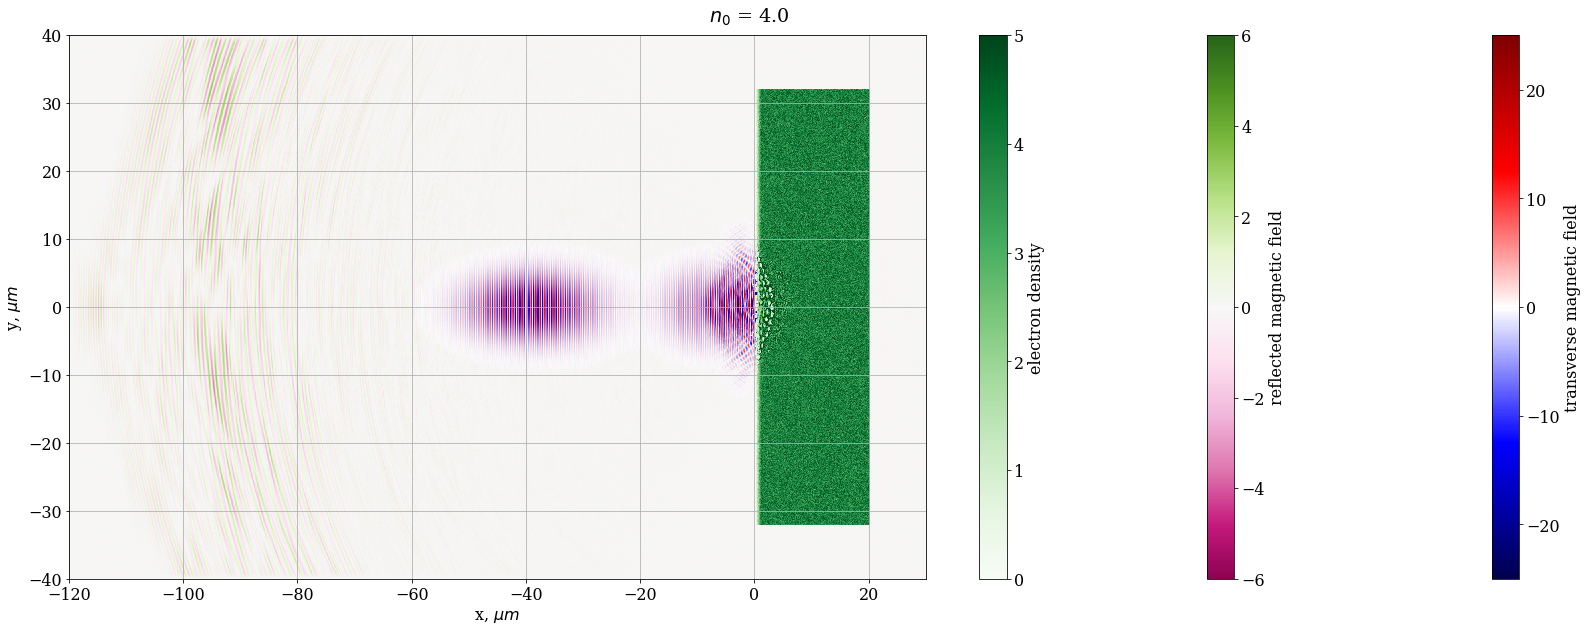

In [24]:
i = 0
for file in files[i:i+1]:
    #by_field_2_i = np.zeros((1200,1200))# массив по времени массивов по азимутальному углу амплитуды поля 
    with gzip.open(r"./data/2D/2D_defect_n4/ez2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
        
i = 2
for file in files[i:i+1]:
    #by_field_2_i = np.zeros((1200,1200))# массив по времени массивов по азимутальному углу амплитуды поля 
    with gzip.open(r"./data/2D/2D_defect_n4/ez2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_r = np.reshape(line_of_data, shape_2dfield)/RelativisticField
#by_field_2_r[:,1200:] = 0

i = 1
for file in files[i:i+1]:
    with gzip.open(r"./data/2D/2D_defect_n4/ez2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_p = np.reshape(line_of_data, shape_2dfield)/RelativisticField
"""for file in files[i:i+1]:
    with gzip.open(path_to_folder_2 +r"/BasicOutput/data/bz2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        bz_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField"""
for file in files[i:i+1]:
    with gzip.open(r"./data/2D/2D_defect_n4/electron2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        ne_2_p = np.reshape(line_of_data, shape_2dfield)/ElectronsPerCell_2D*n0

mask_ne = np.where(ne_2_p > 2e-1, 0.99, 0.01)
mask_br = np.where(abs(by_field_2_p + by_field_2_i) < 2e-1, 0.99, 0.01)
        
fig = plt.figure(figsize=(30,10))
plt.suptitle(r"$n_0$ = 4.0".format(i*100/len(files)), y = 0.92, x = 0.44)

img1= plt.imshow(ne_2_p, cmap='Greens', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = 0, vmax = 5)
img5 = plt.imshow(by_field_2_r, cmap='PiYG', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -6, vmax = 6)
img2 = plt.imshow(by_field_2_p + by_field_2_i, cmap='seismic', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
img4 = plt.imshow(by_field_2_r, alpha = mask_br, cmap='PiYG', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -6, vmax = 6)
img3 = plt.imshow(ne_2_p, alpha = mask_ne, cmap='Greens', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = 0, vmax = 5)

#img2 = plt.imshow(by_field_2_i, cmap='seismic', interpolation='none',extent=[-40, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
#img2 = ax2.imshow(np.sqrt(by_field_2_i**2 + bz_field_2_i**2), cmap='seismic', interpolation='none',extent=[-40, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
plt.colorbar(img2, label = "transverse magnetic field")
plt.colorbar(img5, label = "reflected magnetic field")
plt.colorbar(img1, label = "electron density")
plt.xlabel(r"x, $\mu m$")
plt.ylabel(r"y, $\mu m$")
plt.axis([-120,30,-40,40])
plt.grid()
#fig.savefig("/home/nikita/Documents/science/midIR/paper1/2D_n0_4.0.png", dpi=fig.dpi, format = "png")
plt.show()

In [25]:
fft_r = np.fft.fftshift(np.fft.fft2(by_field_2_r))
fft_i = np.fft.fftshift(np.fft.fft2(by_field_2_i))

freq_x = (np.arange(fft_i.shape[1]) - fft_i.shape[1]/2) / (np.unravel_index(np.argmax(abs(fft_i)), fft_i.shape)[1]-fft_i.shape[1]/2)
freq_y = np.linspace(freq_x[0], freq_x[-1], fft_i.shape[0])

w_x, w_y = np.meshgrid(freq_x, freq_y)

mask = np.where((np.sqrt(w_x**2 + w_y**2) > 0.8/3.0) | (np.sqrt(w_x**2 + w_y**2) < 0.8/50.0))

mask_fft = np.ones_like(fft_i, dtype = int)
mask_fft[mask] = 0

#uniform_filter = ndimage.fourier_gaussian(np.fft.fft2(by_field_2_r), size= (100,120))
uniform_filter = ndimage.fourier_gaussian(np.fft.fft2(by_field_2_r), sigma= 20)

mask_fft.shape

(1600, 3200)

In [26]:
filtered_fft = (fft_r)*mask_fft
filtered_r = np.fft.ifft2((uniform_filter)).real

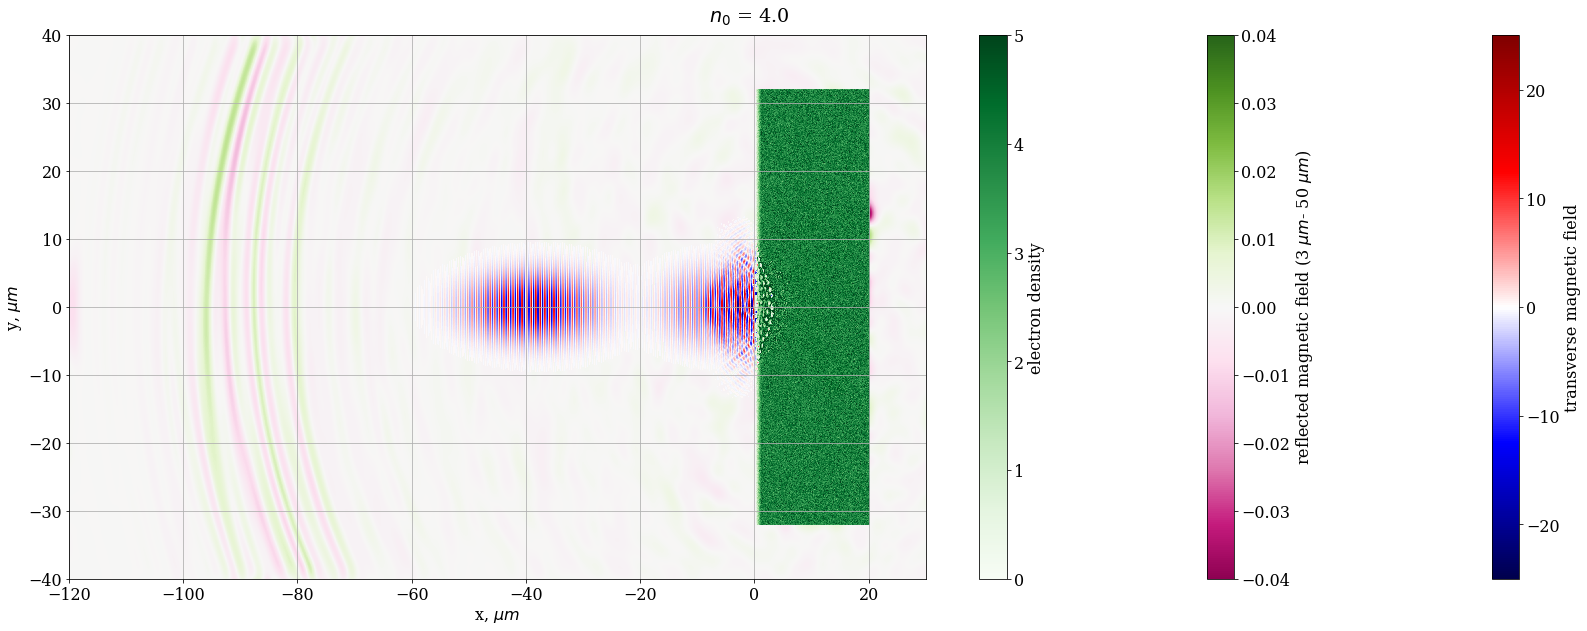

In [27]:
mask_ne = np.where(ne_2_p > 2e-1, 0.99, 0.01)
mask_br = np.where(abs(by_field_2_p + by_field_2_i) < 2e-1, 0.99, 0.01)
        
fig = plt.figure(figsize=(30,10))
plt.suptitle(r"$n_0$ = 4.0".format(i*100/len(files)), y = 0.92, x = 0.44)

img1= plt.imshow(ne_2_p, cmap='Greens', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = 0, vmax = 5)
img5 = plt.imshow((filtered_r), cmap='PiYG', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -0.04, vmax = 0.04)
img2 = plt.imshow(by_field_2_p + by_field_2_i, cmap='seismic', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
img4 = plt.imshow((filtered_r), cmap='PiYG',alpha = mask_br, interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -0.04, vmax = 0.04)
#img4 = plt.imshow(by_field_2_r, alpha = mask_br, cmap='PiYG', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = -6, vmax = 6)
img3 = plt.imshow(ne_2_p, alpha = mask_ne, cmap='Greens', interpolation='none',extent=[-120, 40,-40, 40], aspect='auto', vmin = 0, vmax = 5)

#img2 = plt.imshow(by_field_2_i, cmap='seismic', interpolation='none',extent=[-40, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
#img2 = ax2.imshow(np.sqrt(by_field_2_i**2 + bz_field_2_i**2), cmap='seismic', interpolation='none',extent=[-40, 40,-40, 40], aspect='auto', vmin = -25, vmax = 25)
plt.colorbar(img2, label = "transverse magnetic field")
plt.colorbar(img5, label = "reflected magnetic field (3 $\mu m$- 50 $\mu m$)")
plt.colorbar(img1, label = "electron density")
plt.xlabel(r"x, $\mu m$")
plt.ylabel(r"y, $\mu m$")
plt.axis([-120,30,-40,40])
plt.grid()
plt.show()
#fig.savefig("/home/nikita/Documents/science/midIR/all_of_it/data/2D/2D_n0_4.0.png", format = "png")

# 2D(диаграммы направленности)

## Code

In [21]:
def read_file(dim1, dim2, name_of_file):
    with open(name_of_file, "r") as file:
        line = file.read()
        data = line.split("    ")
        omega = np.zeros(dim1)
        lambda_w = np.zeros(dim1)
        rcs = np.zeros((dim1,dim2))
        for i in range(dim1):
            omega[i] = float(data[0+i*(dim2+2)])
            #print(i)
            lambda_w[i] = float(data[1+i*(dim2+2)])
            rcs[i,:] = data[2+i*(dim2+2):(i+1)*(dim2+2)]
    return omega, lambda_w, rcs

In [22]:
omega_d_04, lambda_w_d_04, rcs_d_04 = read_file(446, 3001, r"./data/2D/defect_n4.0.dat")
omega_d_16, lambda_w_d_16, rcs_d_16 = read_file(446, 3001, r"./data/2D/defect_n16.0.dat")
omega_s_04, lambda_w_s_04, rcs_s_04 = read_file(446, 3001, r"./data/2D/linear_steep_n4.0.dat")
omega_s_16, lambda_w_s_16, rcs_s_16 = read_file(446, 3001, r"./data/2D/linear_steep_n16.0.dat")
phi = 2*np.pi/rcs_d_04.shape[1]*np.arange(rcs_d_04.shape[1])

In [23]:
def graph(lambda_w, lambda_0, dlambda, num_lambda,multiplier):
    neww_rcs_d = []
    lambda_new = dlambda*np.arange(num_lambda)
    for i in range(num_lambda):
        mask = np.where((lambda_w_d_04>(i*dlambda + lambda_0)) & (lambda_w_d_04<((i+1)*dlambda)+lambda_0))
        neww_rcs_d.append(np.sum(rcs_d_04[mask], axis = 0))
    neww_rcs_d = np.array(neww_rcs_d)
    
    neww_rcs_s = []
    for i in range(num_lambda):
        mask = np.where((lambda_w_s_04>i*dlambda) & (lambda_w_s_04<(i+1)*dlambda))
        neww_rcs_s.append(np.sum(rcs_s_04[mask], axis = 0))
    neww_rcs_s = np.array(neww_rcs_s)
    
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m - {:.02f}\mu m $".format(lambda_new[lambda_w]+lambda_0,lambda_new[lambda_w+1]+lambda_0))
    plt.polar(phi[749:-750], neww_rcs_d[lambda_w,749:-750], label = r"$n_0 = 4.0$ defect", linewidth = 2.0)
    plt.polar(phi[749:-750], neww_rcs_s[lambda_w,749:-750]*multiplier, label = r"$n_0 = 4.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

In [24]:
interactive_plot = interactive(graph,
                            lambda_w = widgets.IntSlider(min=0, max = 200,step=1,value= 0),
                            dlambda = widgets.FloatText(value= 7.0),
                            lambda_0 = widgets.FloatText(value= 3.0),
                            num_lambda = widgets.IntSlider(min=0, max = 200,step=1,value= 100),
                            multiplier = widgets.FloatText(value= 20000))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='lambda_w', max=200), FloatText(value=3.0, description='l…

In [25]:
def graph(lambda_w):
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m$".format(lambda_w_d_04[lambda_w]))
    plt.polar(phi, rcs_d_04[lambda_w,:], label = r"$n_0 = 4.0$ defect", linewidth = 2.0)
    plt.polar(phi, rcs_s_04[lambda_w,:]*1000, label = r"$n_0 = 4.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

## Result

In [44]:
interactive_plot = interactive(graph,
                            lambda_w = widgets.IntSlider(min=0, max = rcs_d_04.shape[0]-1,step=1,value= 120),
                            )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=120, description='lambda_w', max=445), Output()), _dom_classes=('widget-…

In [45]:
def graph1(lambda_w):
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m$".format(lambda_w_d_04[lambda_w]))
    plt.polar(phi, rcs_d_16[lambda_w,:], label = r"$n_0 = 16.0$ defect", linewidth = 2.0)
    plt.polar(phi, rcs_s_16[lambda_w,:]*1000, label = r"$n_0 = 16.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

In [46]:
interactive_plot = interactive(graph1,
                            lambda_w = widgets.IntSlider(min=0, max = rcs_d_04.shape[0]-1,step=1,value= 120),
                            )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=120, description='lambda_w', max=445), Output()), _dom_classes=('widget-…